### Scattering Transform Test on MODIS_R2019_2003_95clear_128x128_preproc_std

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.fft
import os

import sys
#sys.path.append('/home/jovyan/scattering_transform/')
sys.path.append('/home/xavier/Projects/Oceanography/python/scattering_transform/')

import scattering

In [3]:
import h5py 

### Show Some Cutouts

In [5]:
os.getenv('OS_SST')

'/home/xavier/Projects/Oceanography/alt_OS/SST/'

In [6]:
#feature_path = './data/modis_data/MODIS_R2019_2003_95clear_128x128_preproc_std.h5'
feature_path = os.path.join(os.getenv('OS_SST'),
                            'MODIS_L2', 'PreProc', 'MODIS_R2019_2003_95clear_128x128_preproc_std.h5')

In [7]:
features = h5py.File(feature_path, 'r')['valid']

In [8]:
np.random.seed(0)

In [9]:
num_samples = features.shape[0]

In [10]:
sampled_id = np.sort(np.random.randint(0, num_samples, 10))

In [11]:
sampled_features = np.squeeze(features[sampled_id], axis=1)

In [12]:
np.max(sampled_features)

2.5312252

In [13]:
np.min(sampled_features)

-3.0235596

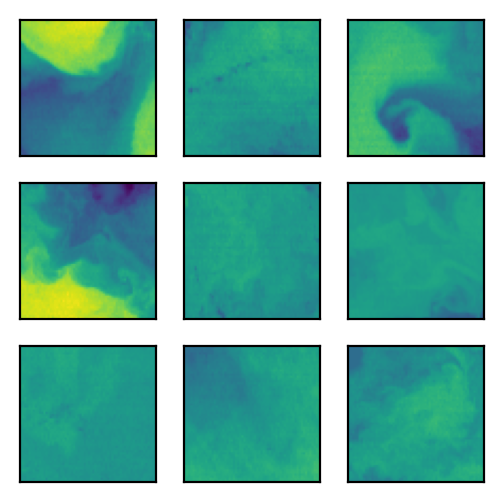

In [14]:
plt.figure(figsize=(3,3), dpi=200)
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(sampled_features[i], vmin=-3.1, vmax=2.6)
    plt.xticks([]); plt.yticks([]); 
plt.show()

# 1. Compute summary statistics

## 1.1 Scattering transform and covariance

In [17]:
2**5

32

In [18]:
M = N = 64; J = 7; L = 4
# Should J=5 and not 7??
st_calc = scattering.Scattering2d(M, N, J, L) 
s_mean = st_calc.scattering_coef(sampled_features)
s_cov  = st_calc.scattering_cov (sampled_features)

In [19]:
print(
    s_mean['for_synthesis_iso'].shape, 
    s_cov['for_synthesis_iso'].shape,
    s_cov['index_for_synthesis_iso'].shape
)

torch.Size([10, 119]) torch.Size([10, 1471]) torch.Size([7, 1471])


## 1.2 Scattering covariance between 2 fields

In [20]:
sampled_features[1].shape

(64, 64)

In [21]:
M = N = 64; J = 7; L = 4
st_calc = scattering.Scattering2d(M, N, J, L) 

image1 = sampled_features[0:1]
image2 = sampled_features[1:2]

s_cov_2fields = st_calc.scattering_cov_2fields(image1, image2)
print('size of isotropic scattering correlations: ', s_cov_2fields['for_synthesis_iso'].shape)
print('size of isotropic C11 coef: ', s_cov_2fields['Corr11_iso'].shape)

size of isotropic scattering correlations:  torch.Size([1, 5406])
size of isotropic C11 coef:  torch.Size([1, 4, 7, 7, 7, 4, 4])


# 2. Build generative models

## 2.1 single-field generation (1-to-1)

input_size:  (1, 64, 64)
# of estimators:  5001
max residual:  6.835359 , mean residual:  0.041467417
max residual:  0.0015323153 , mean residual:  0.00012087885
time used:  32.277377128601074 s


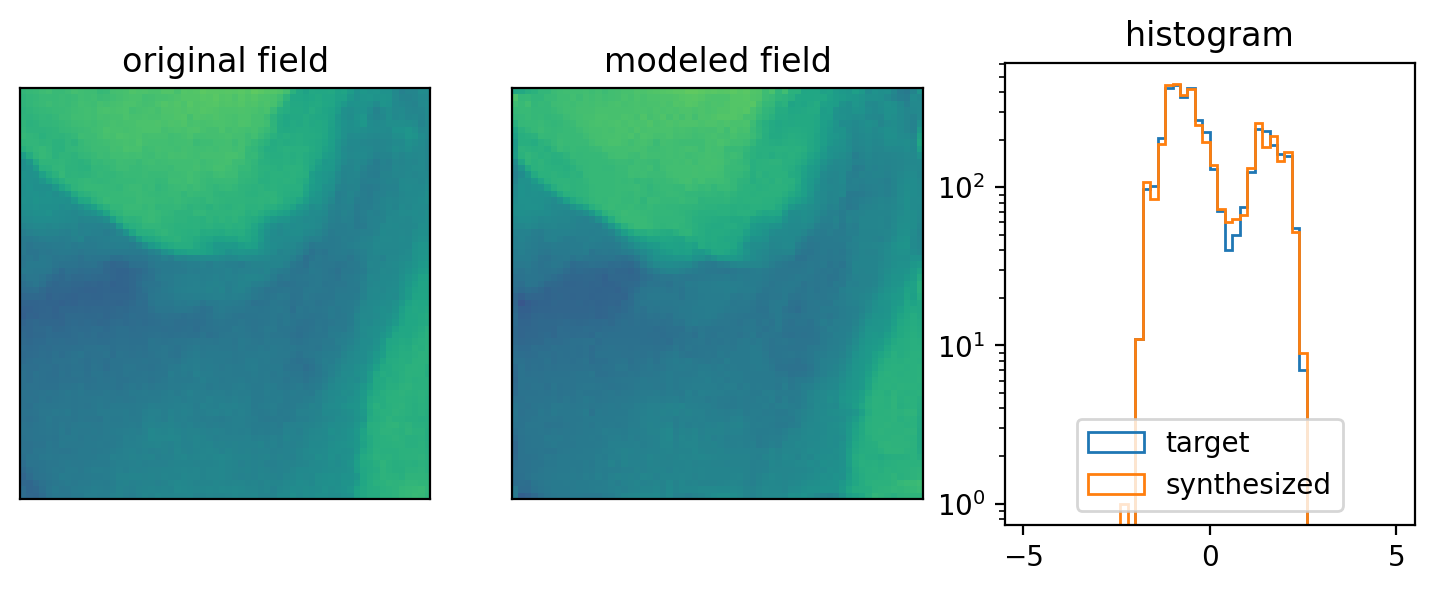

In [22]:
# 1-to-1 generation means that we generate one field matching the statistics of one given field. 
# if the input is a set of fields, then the 1-to-1 mode will synthesise them independently

# load image
image_target = image_input = sampled_features[0:1]


# synthesize
image_syn = scattering.synthesis('s_cov', image_target, seed=0, remove_edge=True)

# show
scattering.show(image_target, image_syn, (-5, 5))

## 2.2 threshold clipping generation

10
input_size:  (10, 64, 64)
# of estimators:  143
max residual:  5.990832 , mean residual:  0.97540367
max residual:  0.004793972 , mean residual:  0.00067311095
time used:  235.77387022972107 s


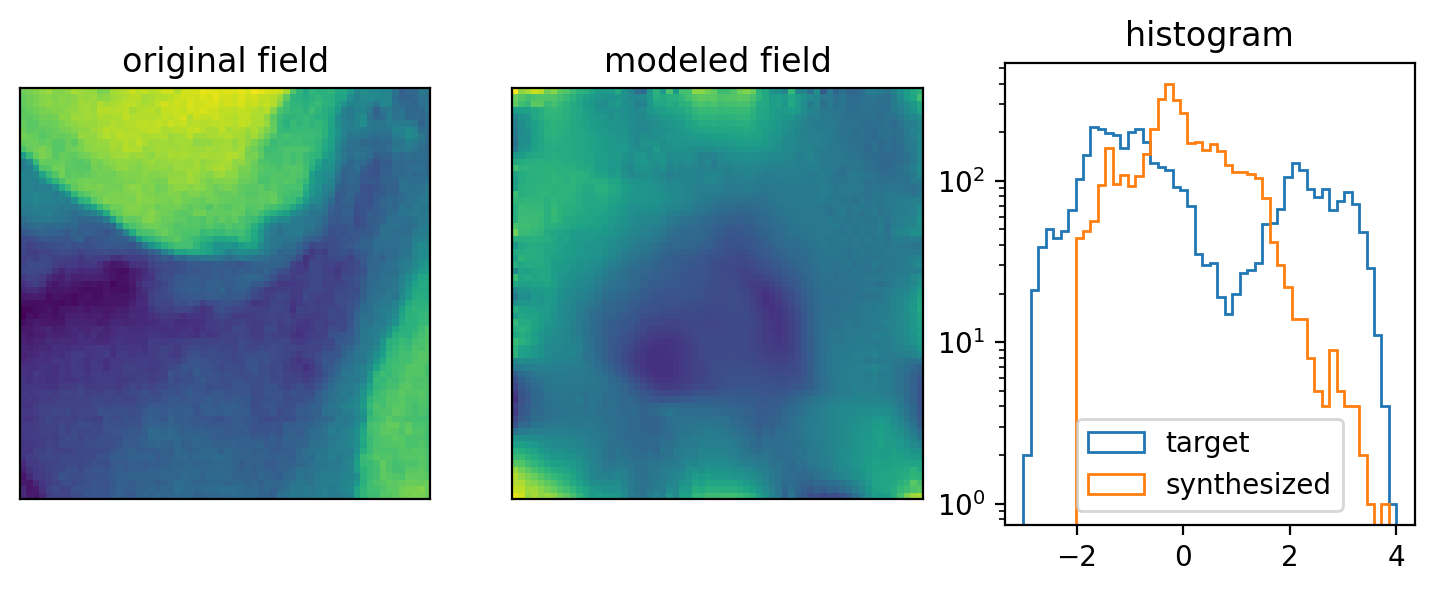

In [17]:
# load a set of 20 cosmic web fields
image_target = scattering.whiten(sampled_features, overall=True)

# get scattering coefficients
M, N, J, L = image_target.shape[-2], image_target.shape[-1], 7, 4
st_calc = scattering.Scattering2d(M, N, J, L)
s_cov = scattering.chunk_model(image_target, st_calc, nchunks=10) 
# same as "s_cov = st_calc.scattering_cov(image_target)" but avoid memory problem

# compute the thresholding selection
threshold_list = [2] # set a list of thresholding sigma
_, _, _, threshold_func, mask_list = scattering.prepare_threshold_func(s_cov, threshold_list)
mask = mask_list[0]

# set N' of the emsemble generation (N-to-N')
Np = 10

# synthesis
image_syn = scattering.synthesis(
    's_cov_func', image_target, seed=0, ensemble=True, N_ensemble=Np,
    s_cov_func=threshold_func, s_cov_func_params=mask, J=J, L=L, remove_edge=True)

# show
scattering.show(image_target[:1], image_syn[:1], (-3, 4))

### 2.3 more flexible code using "estimator" mode

# of estimators:  143
max residual:  5.719248 , mean residual:  0.845152
max residual:  12.255711 , mean residual:  2.428797
time used:  246.9993598461151 s


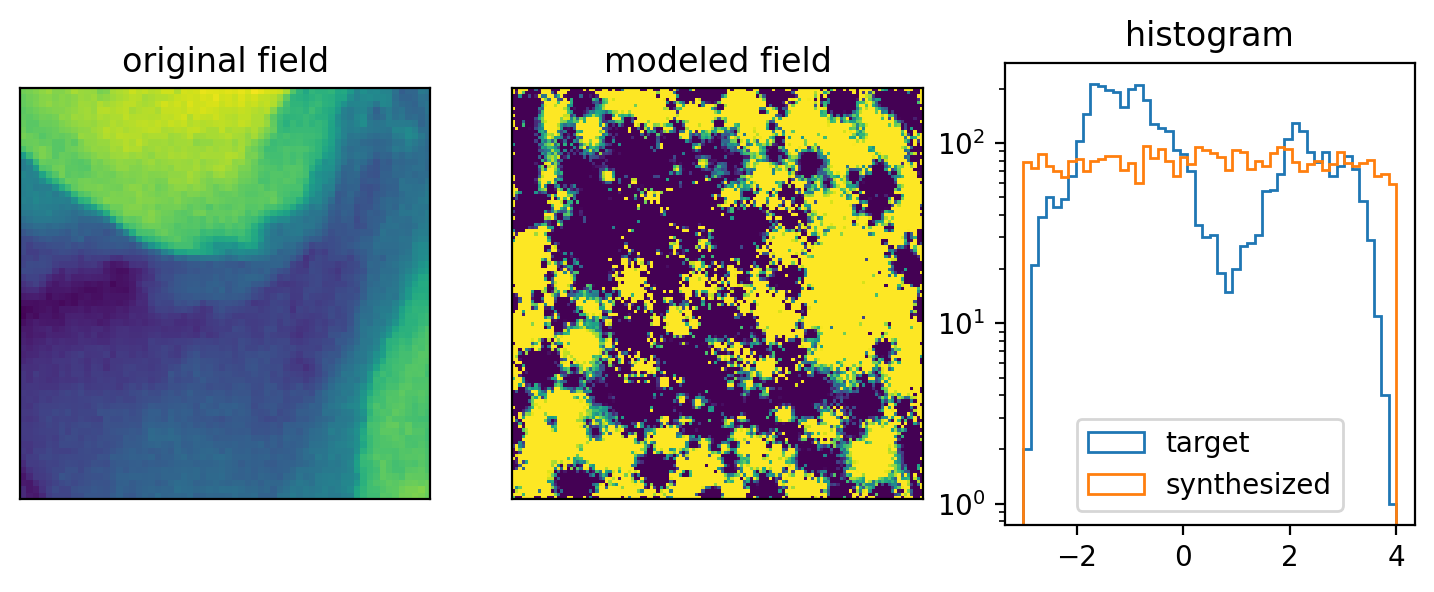

In [18]:
# or, the following code will do the same thing, but using the "estimator" mode,
# which means we specify the target estimator values instead of target images.

# prepare reference power spectrum for normalization and prepare target coef
P00 = torch.exp(s_cov['for_synthesis'][:,1:1+J*L].mean(0).reshape((1,J,-1)))
target_coef = threshold_func(s_cov, mask).mean(0)[None,:].cuda()
# synthesis
image_syn = scattering.synthesis(
    's_cov_func', target_coef, seed=0, ensemble=True, N_ensemble=Np,
    s_cov_func=threshold_func, s_cov_func_params=mask, J=J, L=L, 
    mode='estimator', M=M*2, N=N*2, reference_P00=P00.cuda(), remove_edge=True)
# note that we can specify the size of generated fields now,
# which is set to be (M*2, N*2) in this example
# if we set it back to (M, N), this example give the same result as the above code

# show
scattering.show(image_target[:1], image_syn[:1], (-3, 4)) 
# note that image_syn[0] now has a size of (M*2, N*2) = (512, 512), four times larger
# than the original field.

## 2.4 interpret coefficients by generation

### example 1: interpolation between textures

# of estimators:  1471
max residual:  0.81589675 , mean residual:  0.01844273
max residual:  0.042244945 , mean residual:  0.0011969126
time used:  159.8176567554474 s


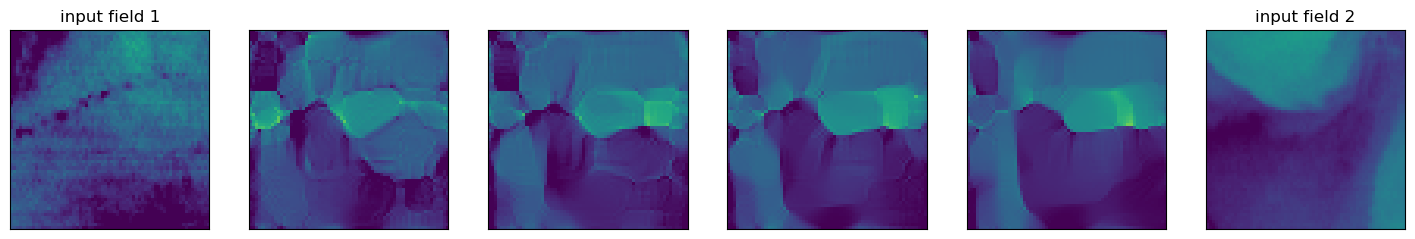

In [19]:
# load two images
M = N = 64; J = 7; L = 4
image_target1 = scattering.whiten(sampled_features[1:2])
image_target2 = scattering.whiten(sampled_features[0:1])

# calculate scattering correlations coefficients for each of them
st_calc = scattering.Scattering2d(M, N, J, L)
s_cov1 = st_calc.scattering_cov(image_target1)
s_cov2 = st_calc.scattering_cov(image_target2)

# linearly interpolate the coefficients between image1 and image2
coef_target_list = []
param_list = [0.75, 0.5, 0.25, 0.]
for factor in param_list:
    coef_target_list.append(
        factor * s_cov1['for_synthesis_iso'] + (1-factor) * s_cov2['for_synthesis_iso'])

# synthesize based on the values of interpolated coefficients
image_syn = scattering.synthesis(
    's_cov_iso', mode='estimator', M=M, N=N, J=J, L=L, 
    target=torch.cat(coef_target_list, dim=0),
    image_init=image_target1 * np.ones((len(param_list),1,1)),
    steps=200, seed=0, remove_edge=True,
)

# plot result
image_series = np.concatenate(
    (image_target1[0:1], image_syn, image_target2[0:1]), axis=0)

plt.figure(figsize=(len(image_series)*3,3),dpi=100)
for i in range(len(image_series)):
    plt.subplot(1,len(image_series),i+1)
    plt.imshow(image_series[i], vmin=-1.5, vmax=5)
    if i == 0: plt.title('input field 1')
    if i == len(image_series)-1: plt.title('input field 2')
    plt.xticks([]); plt.yticks([])

### example 2: artificially increase or decrease some coefficients

In [20]:
# load image
select = np.array([0,1,3,5])
image_target = scattering.whiten(sampled_features[select])

# define calculators
M, N, J, L = image_target.shape[-2], image_target.shape[-1], 7, 4
st_calc = scattering.Scattering2d(M, N, J, L)

# calculate estimators
s_cov_set = st_calc.scattering_cov(image_target)
index_type, j1, j2, j3, l1, l2, l3 = s_cov_set['index_for_synthesis']

# excluding S1, because it depends on others
def func_noS1(s_cov_set, param):
    return s_cov_set['for_synthesis'][:,index_type!=2]

# of estimators:  11677
max residual:  1.9433769 , mean residual:  0.021162022
max residual:  0.8954432 , mean residual:  0.008682031
time used:  235.4924557209015 s


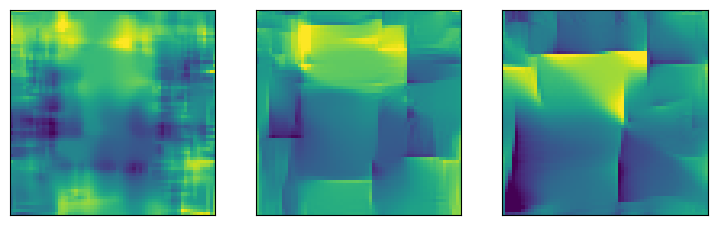

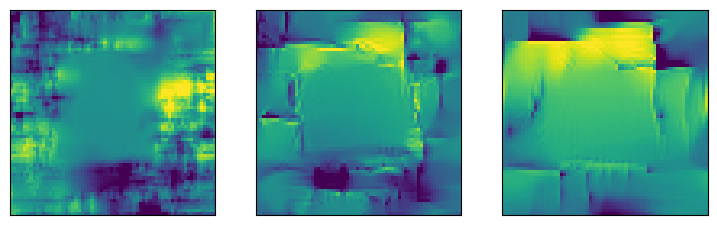

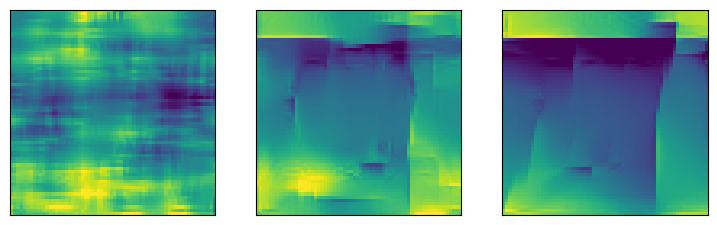

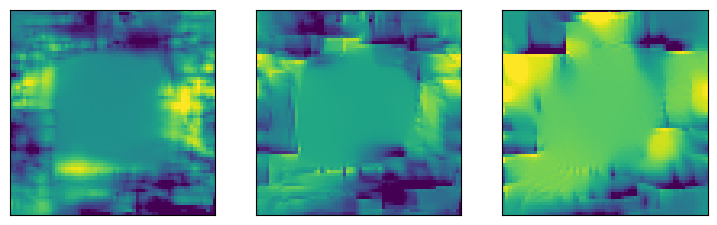

In [21]:
# change the overal amplitude of both C01 and C11 coefficients
s_cov_list = []
param_list = [0, 1, 3]
for factor in param_list:
    s_cov = s_cov_set['for_synthesis']*1.
    s_cov[:,(index_type==3)+(index_type==4)] *= factor # C01 are scaled by factor
    s_cov[:,(index_type==5)+(index_type==6)] *= factor # C11 are scaled by factor
    for i in range(len(s_cov)): s_cov_list.append(s_cov[i:i+1])

# synthesize based on values of coefficients
N_param = len(param_list)
image_syn = scattering.synthesis(
    's_cov_func', mode='estimator', M=M, N=N, J=J, L=L, s_cov_func=func_noS1,
    target=torch.cat(s_cov_list, dim=0)[:,index_type!=2], 
    image_init=(image_target[None,...] * np.ones((N_param,1,1,1))).reshape(-1,M,N),
    remove_edge=True
)

# plot result
for idx_img in range(len(image_target)): 
    plt.figure(figsize=(len(param_list)*3,3), dpi=100)
    for i in range(len(param_list)):
        plt.subplot(1, len(param_list), i+1)
        plt.imshow(image_syn[idx_img+len(image_target)*i], vmin=-2.5, vmax=2.5)
        plt.xticks([]); plt.yticks([])
    plt.show()

## 2.5 two-field generation using cross scattering covariance

In [ ]:
# load image
image_target = sampled_features[3:4]
image_b      = sampled_features[4:5]

# synthesize
image_syn = scattering.synthesis('s_cov_2fields_iso', mode='image', 
    target=image_target, image_b=image_b, image_init='random phase',
    steps=800, seed=0, remove_edge=True,
)

input_size:  (1, 64, 64)


In [ ]:
plt.figure(figsize=(6,3),dpi=100)
plt.subplot(121); plt.imshow(image_target[0,:128,:128], vmin=-1.5, vmax=1.5)
plt.subplot(122); plt.imshow(image_syn   [0,:128,:128], vmin=-1.5, vmax=1.5)
plt.show()

### for comparison: single field synthesis

In [ ]:
# load image
image_target = sampled_features[3:4]
image_b      = sampled_features[4:5]
# s_cov_iso single field
image_syn = scattering.synthesis('s_cov_iso', image_target, seed=0, remove_edge=True, image_init='random phase')
# plot
plt.figure(figsize=(6,3),dpi=100)
plt.subplot(121); plt.imshow(image_target[0,:128,:128], vmin=-2, vmax=2)
plt.subplot(122); plt.imshow(image_syn   [0,:128,:128], vmin=-2, vmax=2)
plt.show()

## Synthesized Images on Kube

In [3]:
feature_path = './data/modis_data/modis_image_syn_scattering_test.h5'

In [7]:
features = h5py.File(feature_path, 'r')['scattering_test']

In [23]:
features.shape

(99, 1, 64, 64)

In [21]:
min_features, max_features = np.min(features), np.max(features)

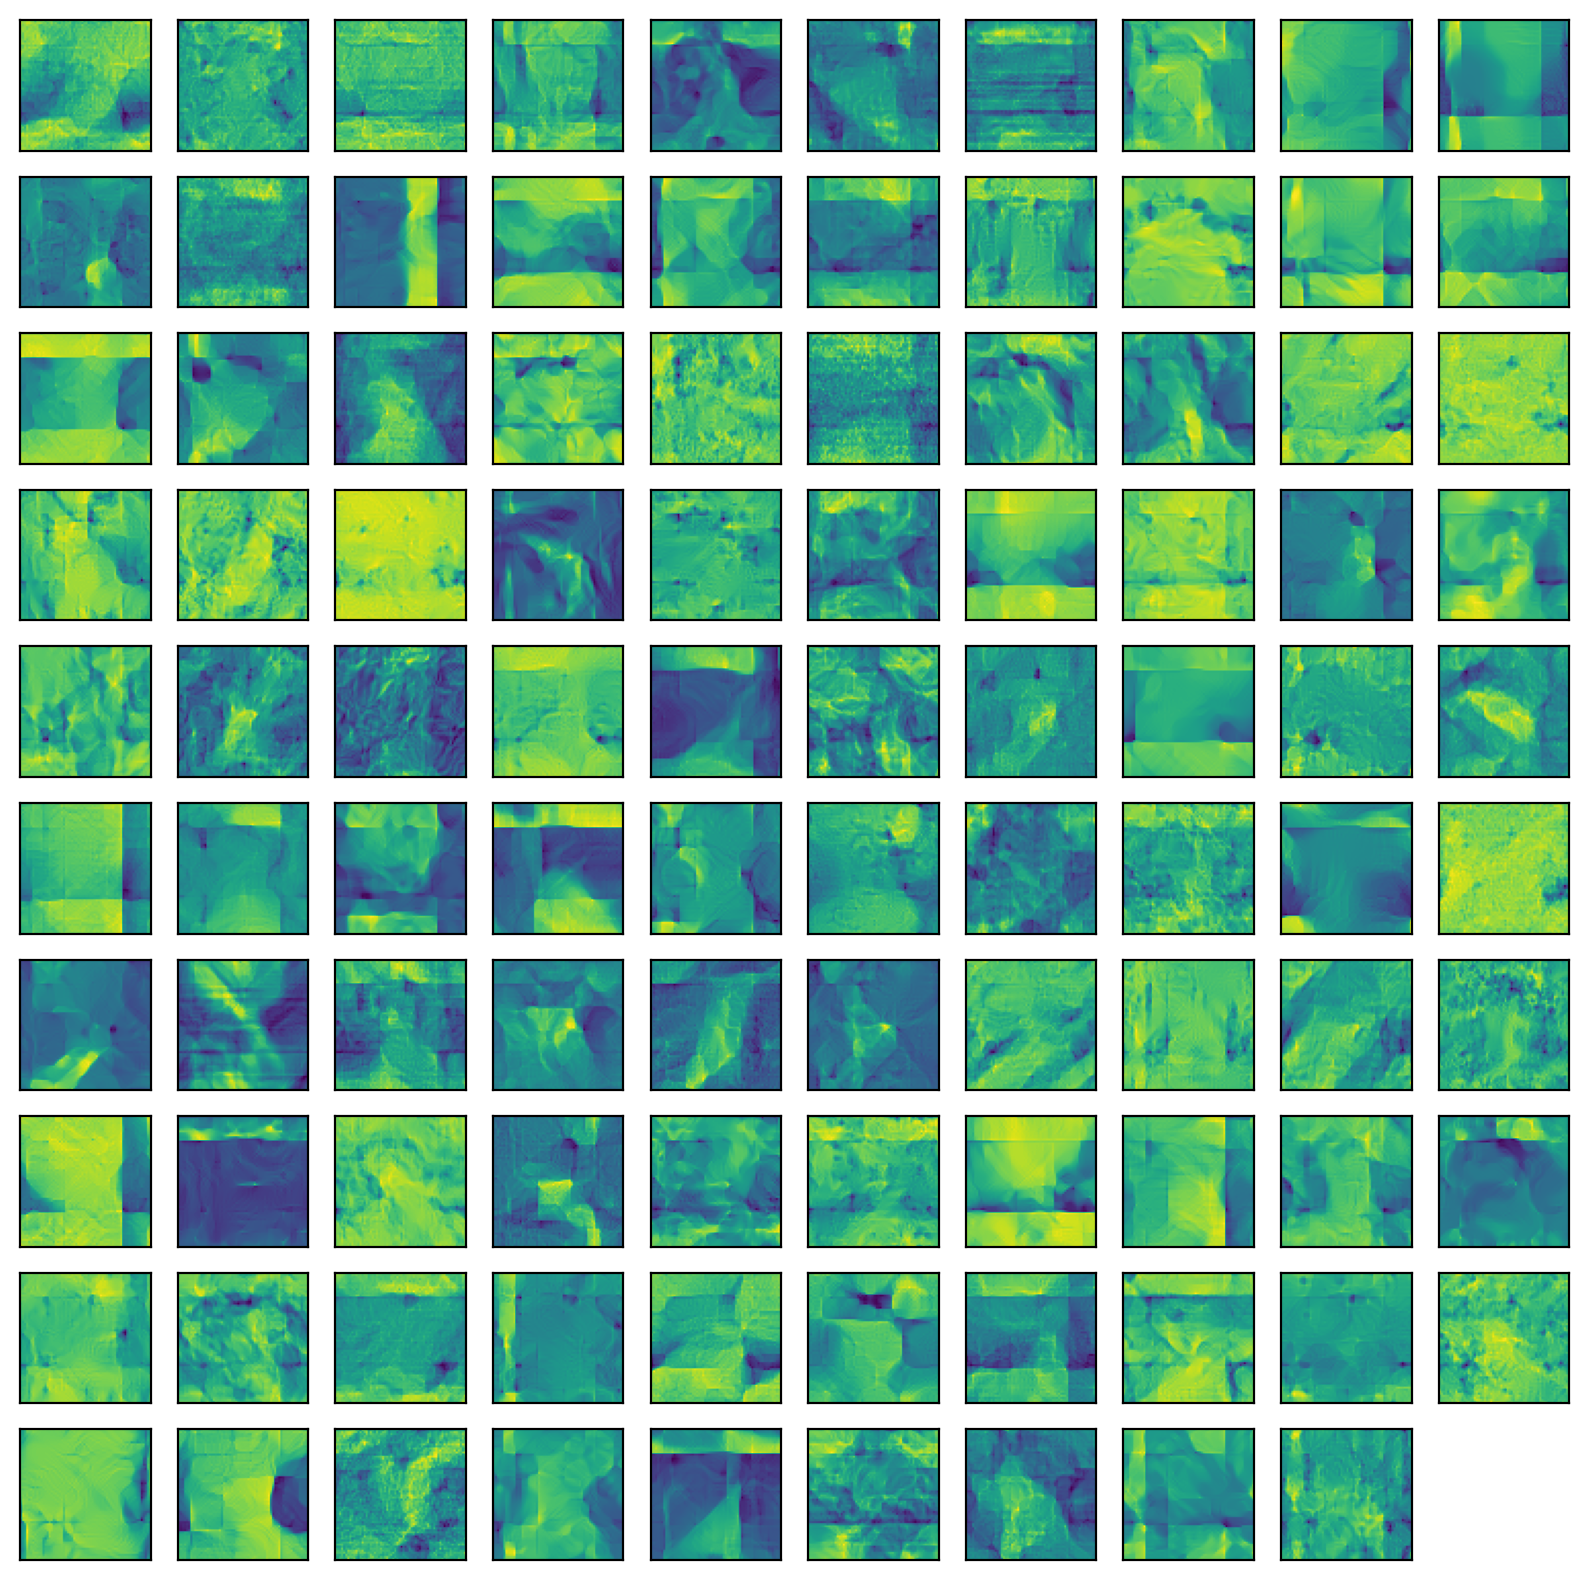

In [25]:
plt.figure(figsize=(10,10), dpi=200)
for i in range(99):
    plt.subplot(10, 10, i+1)
    plt.imshow(features[i].squeeze()) #vmin=min_features, vmax=max_features)
    plt.xticks([]); plt.yticks([]); 
plt.show()

In [23]:
features.close()

AttributeError: 'Dataset' object has no attribute 'close'